In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Conv2DTranspose,
                                     concatenate, BatchNormalization, Dropout)
from tensorflow.keras.models import Model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split

# Set a seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

# Define the dataset directory
data_dir = "images_labels"


In [5]:
# List all .tif files in the folder and sort them
all_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.tif')])

# Check if the total number of files is even
if len(all_files) % 2 != 0:
    raise ValueError("The number of .tif files in the directory is not even. Each image should have a corresponding mask.")

# Pair the files: assume the first file is an image and the second is its corresponding mask, and so on.
image_paths = []
mask_paths = []

for i in range(0, len(all_files), 2):
    image_paths.append(os.path.join(data_dir, all_files[i]))
    mask_paths.append(os.path.join(data_dir, all_files[i+1]))

print("Total pairs found:", len(image_paths))

# Now split the pairs into training and validation sets (e.g., 80% training, 20% validation)
train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=seed
)

print("Training pairs:", len(train_img_paths))
print("Validation pairs:", len(val_img_paths))

Total pairs found: 1671
Training pairs: 1336
Validation pairs: 335


In [7]:
def load_image(image_path, target_size=(128, 128)):
    """
    Loads an image from disk, converts it from BGR to RGB, resizes to target_size,
    normalizes pixel values to [0, 1], and returns a float32 array.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error reading image: {image_path}")
    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Resize image to target size
    image = cv2.resize(image, target_size)
    # Normalize to [0, 1]
    image = image / 255.0
    return image.astype(np.float32)

def load_mask(mask_path, target_size=(128, 128)):
    """
    Loads a mask from disk in grayscale, resizes to target_size,
    normalizes pixel values to [0, 1], expands channel dimension, and returns a float32 array.
    """
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise ValueError(f"Error reading mask: {mask_path}")
    # Resize mask; use INTER_NEAREST to preserve label values
    mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)
    # Normalize to [0, 1]
    mask = mask / 255.0
    # Expand dimensions to (H, W, 1)
    mask = np.expand_dims(mask, axis=-1)
    return mask.astype(np.float32)

Training sample:


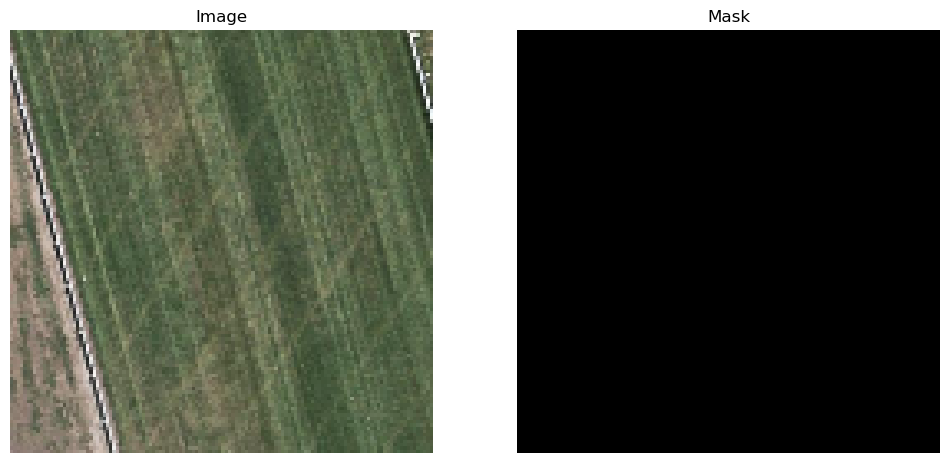

Validation sample:


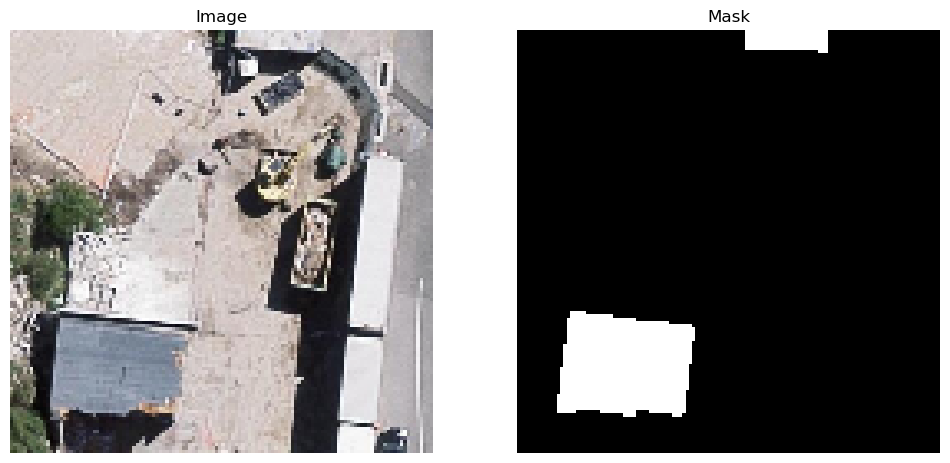

In [9]:
def visualize_sample(image_path, mask_path):
    """
    Loads and displays a single image and its corresponding mask side-by-side.
    """
    image = load_image(image_path)
    mask = load_mask(mask_path)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")
    
    axs[1].imshow(mask.squeeze(), cmap='gray')
    axs[1].set_title("Mask")
    axs[1].axis("off")
    
    plt.show()

# Visualize a random sample from the training set
sample_idx = random.randint(0, len(train_img_paths) - 1)
print("Training sample:")
visualize_sample(train_img_paths[sample_idx], train_mask_paths[sample_idx])

# Visualize a random sample from the validation set
sample_idx = random.randint(0, len(val_img_paths) - 1)
print("Validation sample:")
visualize_sample(val_img_paths[sample_idx], val_mask_paths[sample_idx])

In [11]:
def load_dataset(image_paths, mask_paths):
    """
    Loads all images and masks from the provided file paths and returns them as NumPy arrays.
    """
    images = []
    masks = []
    for img_path, msk_path in zip(image_paths, mask_paths):
        images.append(load_image(img_path))
        masks.append(load_mask(msk_path))
    return np.array(images), np.array(masks)

# Load training data
X_train, Y_train = load_dataset(train_img_paths, train_mask_paths)
# Load validation data
X_val, Y_val = load_dataset(val_img_paths, val_mask_paths)

print("Training images shape:", X_train.shape)
print("Training masks shape:", Y_train.shape)
print("Validation images shape:", X_val.shape)
print("Validation masks shape:", Y_val.shape)

Training images shape: (1336, 128, 128, 3)
Training masks shape: (1336, 128, 128, 1)
Validation images shape: (335, 128, 128, 3)
Validation masks shape: (335, 128, 128, 1)


In [13]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024, seed=seed).batch(16).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(16).prefetch(tf.data.AUTOTUNE)

In [15]:
def build_improved_unet(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)
    
    # Encoder Block 1
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    # Encoder Block 2
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    
    # Encoder Block 3
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    
    # Encoder Block 4
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    bn = Conv2D(512, (3, 3), activation='relu', padding='same')(p4)
    bn = BatchNormalization()(bn)
    bn = Conv2D(512, (3, 3), activation='relu', padding='same')(bn)
    bn = BatchNormalization()(bn)
    bn = Dropout(0.5)(bn)
    
    # Decoder Block 1
    u1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn)
    concat1 = concatenate([u1, c4])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat1)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # Decoder Block 2
    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    concat2 = concatenate([u2, c3])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat2)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)
    
    # Decoder Block 3
    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    concat3 = concatenate([u3, c2])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat3)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)
    
    # Decoder Block 4
    u4 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    concat4 = concatenate([u4, c1])
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(concat4)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    
    # Output layer: 1 channel with sigmoid activation for binary segmentation
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define input shape based on your images
input_shape = (128, 128, 3)

# Build and compile the improved model
model = build_improved_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary to review the architecture
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[

 Total params: 7,771,873 (29.65 MB)

 Trainable params: 7,765,985 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

In [17]:
# Define training parameters
epochs = 10  # You may need to adjust the number of epochs based on your dataset and desired accuracy
batch_size = 16

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 369s 4s/step - accuracy: 0.6893 - loss: 0.6322 - val_accuracy: 0.1202 - val_loss: 41.3798
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 283s 3s/step - accuracy: 0.8356 - loss: 0.4001 - val_accuracy: 0.7968 - val_loss: 0.4507
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8600 - loss: 0.3139 - val_accuracy: 0.8334 - val_loss: 0.3856
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 257s 3s/step - accuracy: 0.8745 - loss: 0.2700 - val_accuracy: 0.8433 - val_loss: 0.3634
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.8790 - loss: 0.2497 - val_accuracy: 0.8462 - val_loss: 0.3630
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.8702 - loss: 0.2548 - val_accuracy: 0.8859 - val_loss: 0.2374
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step - accuracy: 0.8835 - loss: 0.2353 - val_accuracy: 0.8885 - val_loss: 0.2328
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.8792 - loss: 0.2405 - val_accuracy: 0.8886 - 

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 861ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step


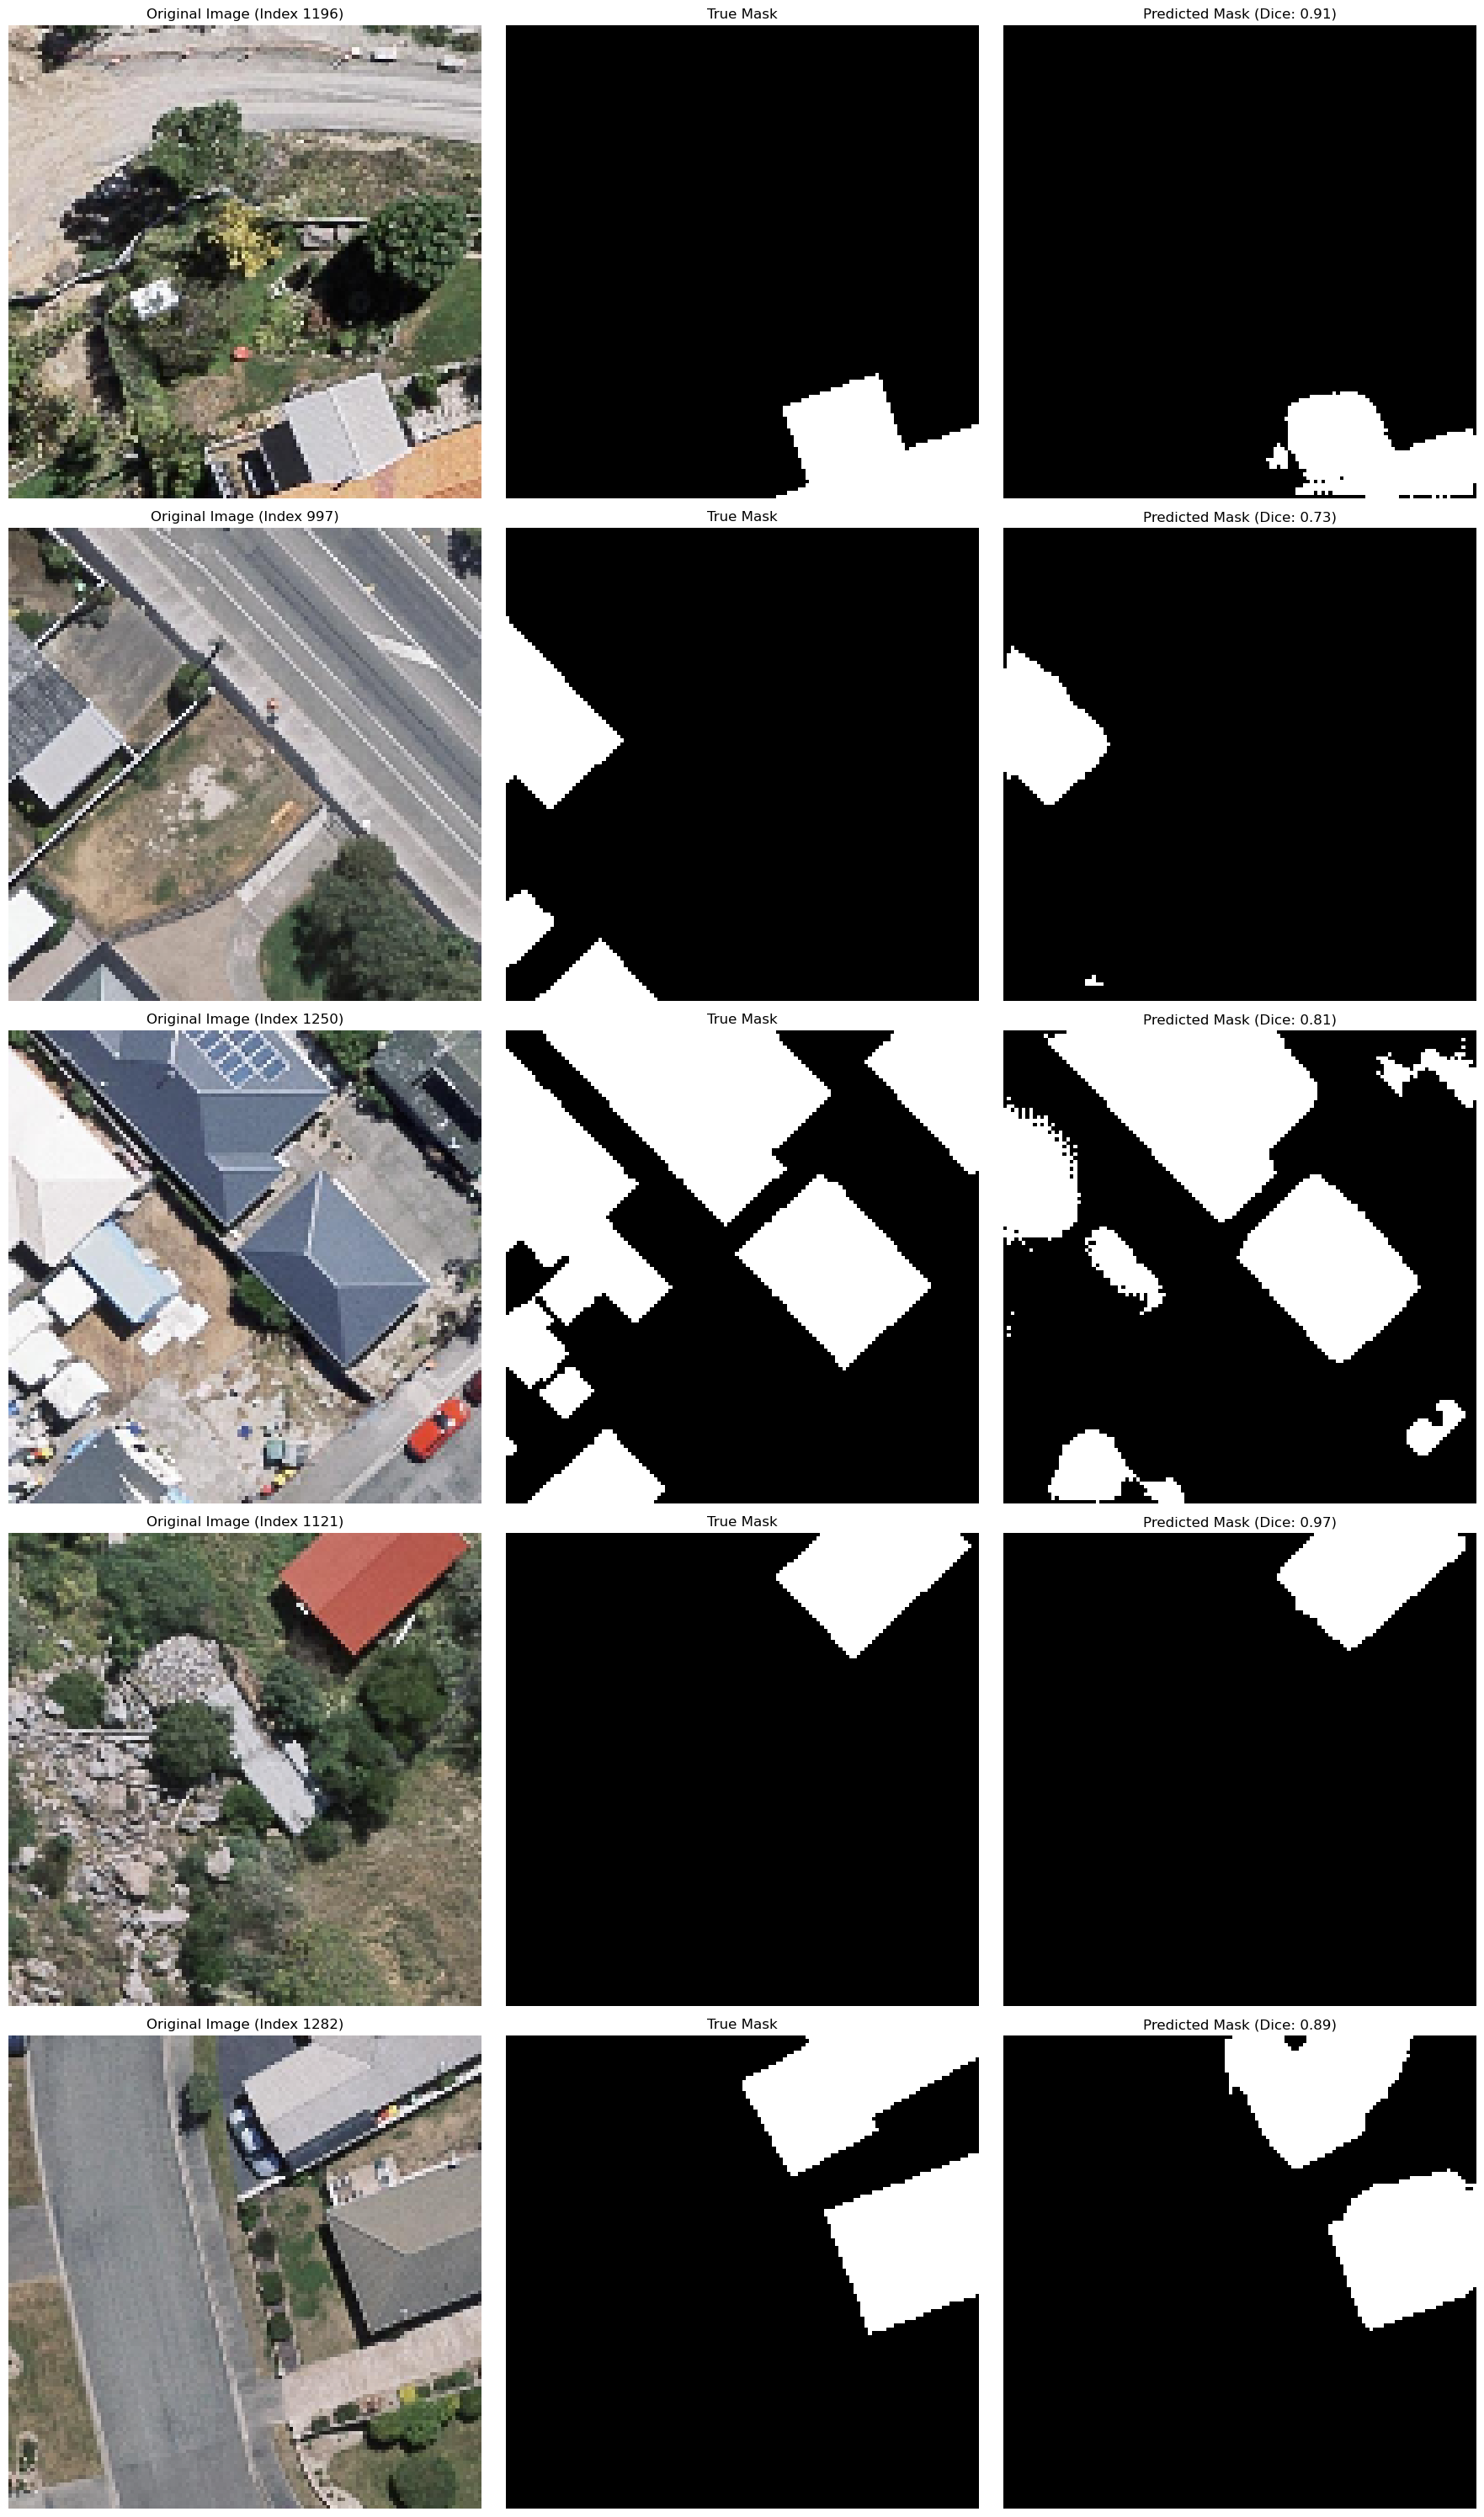

In [19]:
def dice_coefficient(true_mask, pred_mask, smooth=1e-7):
    """
    Computes the Dice coefficient between the true mask and predicted mask.
    Both inputs should be binary (0 or 1) and of the same shape.
    """
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()
    intersection = np.sum(true_flat * pred_flat)
    return (2. * intersection + smooth) / (np.sum(true_flat) + np.sum(pred_flat) + smooth)

def visualize_good_train_predictions(n=5, dice_threshold=0.7):
    """
    Visualizes n training samples where the predicted masks are "good" based on the Dice coefficient.
    Only samples with a Dice coefficient above dice_threshold and non-empty predicted masks are shown.
    """
    indices = list(range(X_train.shape[0]))
    random.shuffle(indices)  # Randomize order
    selected = []  # List to hold tuples: (index, dice)
    
    for idx in indices:
        image = X_train[idx]
        true_mask = Y_train[idx]
        
        # Generate prediction; model expects a batch dimension.
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        # Convert to a binary mask using 0.5 as threshold.
        pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
        
        # Compute Dice coefficient between true mask and predicted mask.
        dice = dice_coefficient(true_mask.squeeze(), pred_mask_bin.squeeze())
        
        # Check if the predicted mask is non-empty and meets the Dice threshold.
        if dice >= dice_threshold and np.sum(pred_mask_bin) > 0:
            selected.append((idx, dice))
        
        if len(selected) >= n:
            break

    if not selected:
        print("No training samples met the criteria.")
        return

    # Set up the figure: each sample is shown in one row with 3 columns.
    num_samples = len(selected)
    fig, axs = plt.subplots(num_samples, 3, figsize=(18, num_samples * 6))
    
    # If only one sample is selected, ensure axs is 2D.
    if num_samples == 1:
        axs = np.expand_dims(axs, axis=0)
    
    for i, (idx, dice) in enumerate(selected):
        image = X_train[idx]
        true_mask = Y_train[idx]
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
        pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
        
        axs[i, 0].imshow(image)
        axs[i, 0].set_title(f"Original Image (Index {idx})")
        axs[i, 0].axis("off")
        
        axs[i, 1].imshow(true_mask.squeeze(), cmap='gray')
        axs[i, 1].set_title("True Mask")
        axs[i, 1].axis("off")
        
        axs[i, 2].imshow(pred_mask_bin.squeeze(), cmap='gray')
        axs[i, 2].set_title(f"Predicted Mask (Dice: {dice:.2f})")
        axs[i, 2].axis("off")
    
    plt.tight_layout()
    plt.show()

# Call the function to visualize multiple good training predictions.
visualize_good_train_predictions(n=5, dice_threshold=0.7)

In [21]:
def calculate_mask_area(mask, threshold=0.5):
    """
    Calculates the area (in pixel count) of a mask for a given image.
    
    Args:
        mask (numpy.ndarray): A segmentation mask as a numpy array. Expected shape can be either (H, W) or (H, W, 1).
        threshold (float): The threshold to determine if a pixel is "on" (part of the mask). Defaults to 0.5.
    
    Returns:
        int: The number of pixels in the mask that are above the threshold.
    """
    # If mask has an extra channel dimension, remove it.
    if mask.ndim == 3 and mask.shape[-1] == 1:
        mask = np.squeeze(mask, axis=-1)
    
    # Convert mask to binary using the threshold.
    binary_mask = (mask > threshold).astype(np.uint8)
    
    # Sum the binary mask to get the area (i.e., count of "on" pixels).
    area = int(np.sum(binary_mask))
    return area

Validation Loss: 0.2221, Validation Accuracy: 0.8903
Found 103 good samples out of 335 total validation samples.


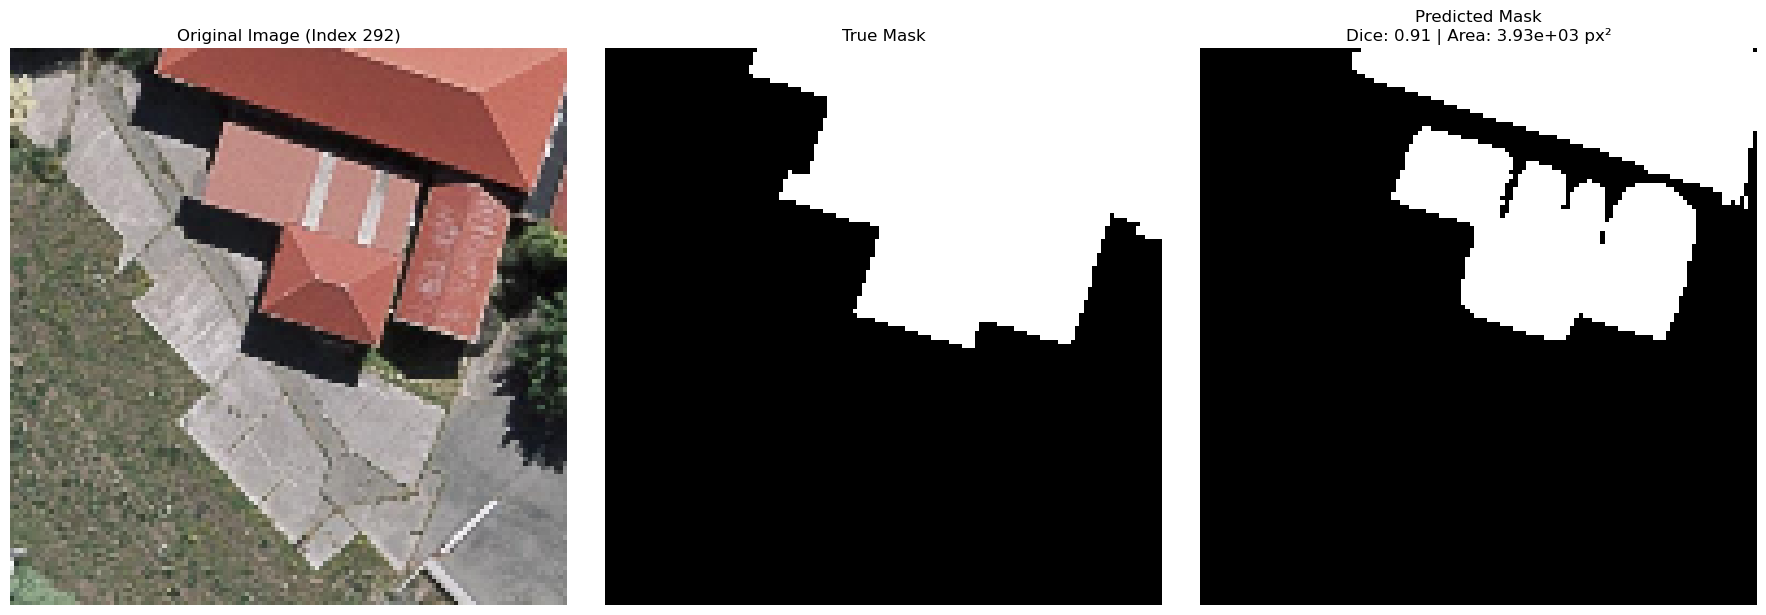

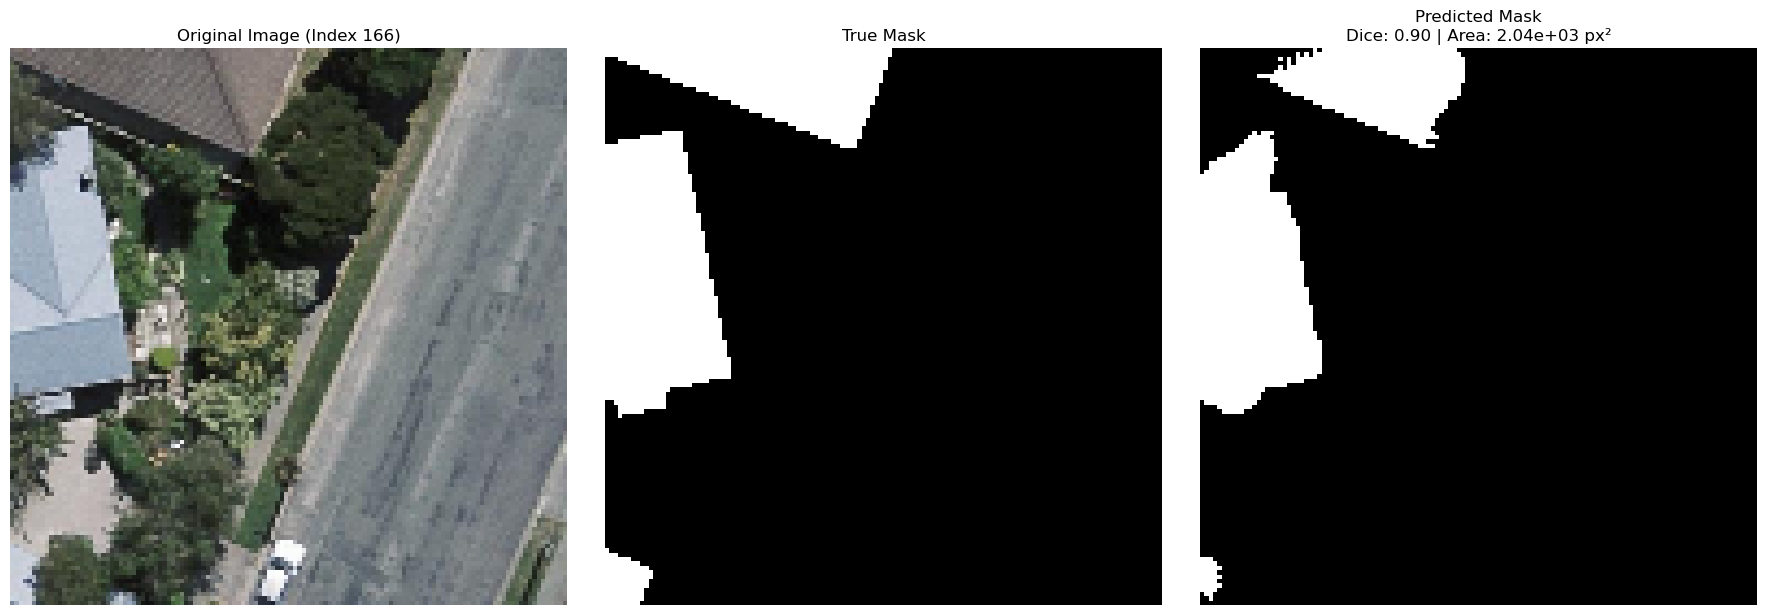

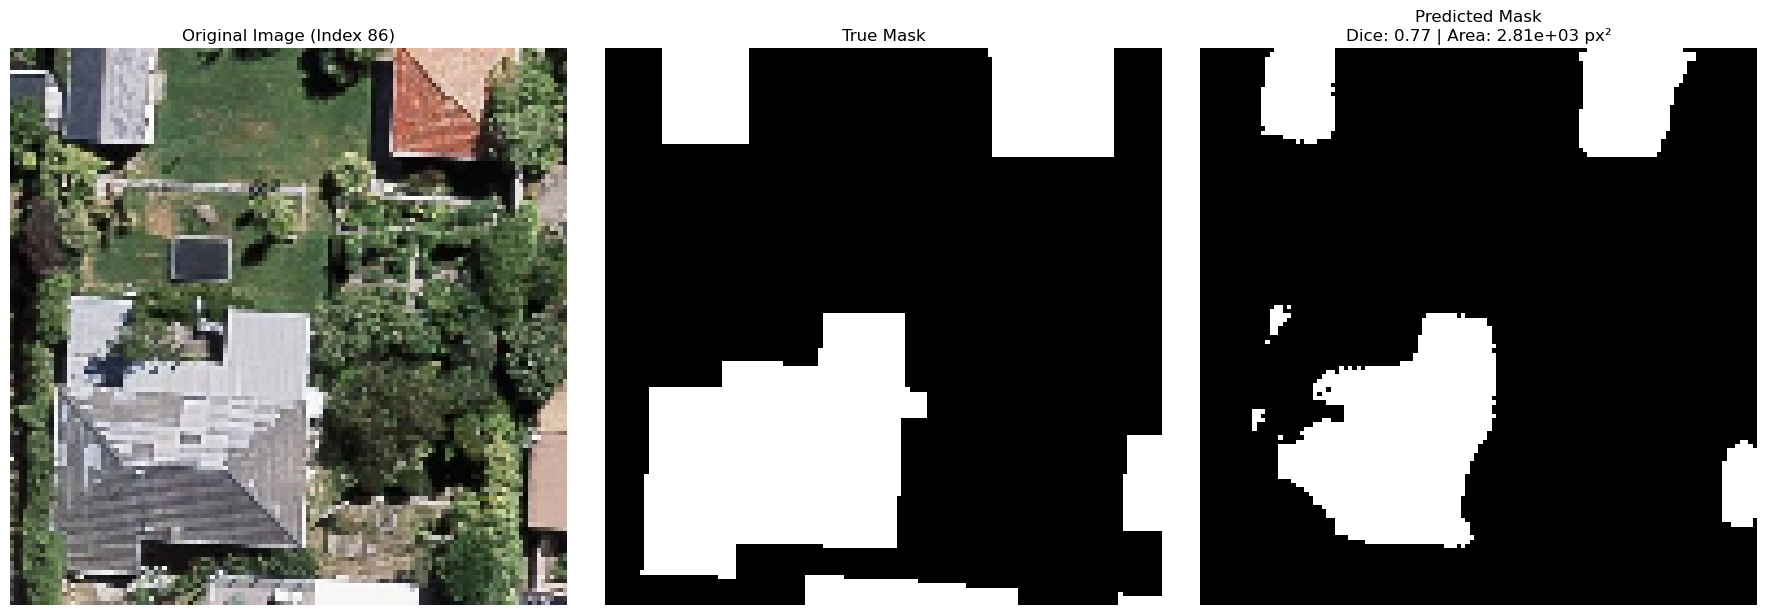

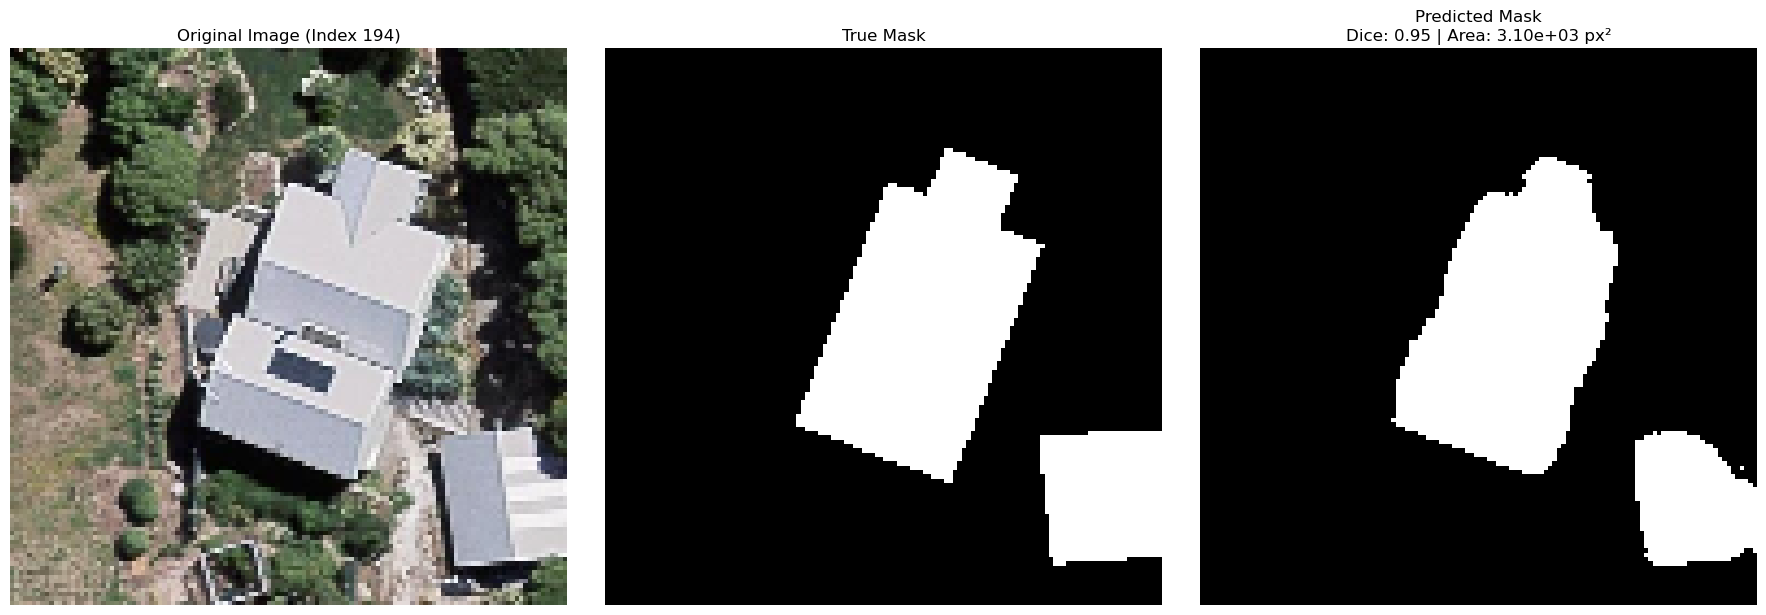

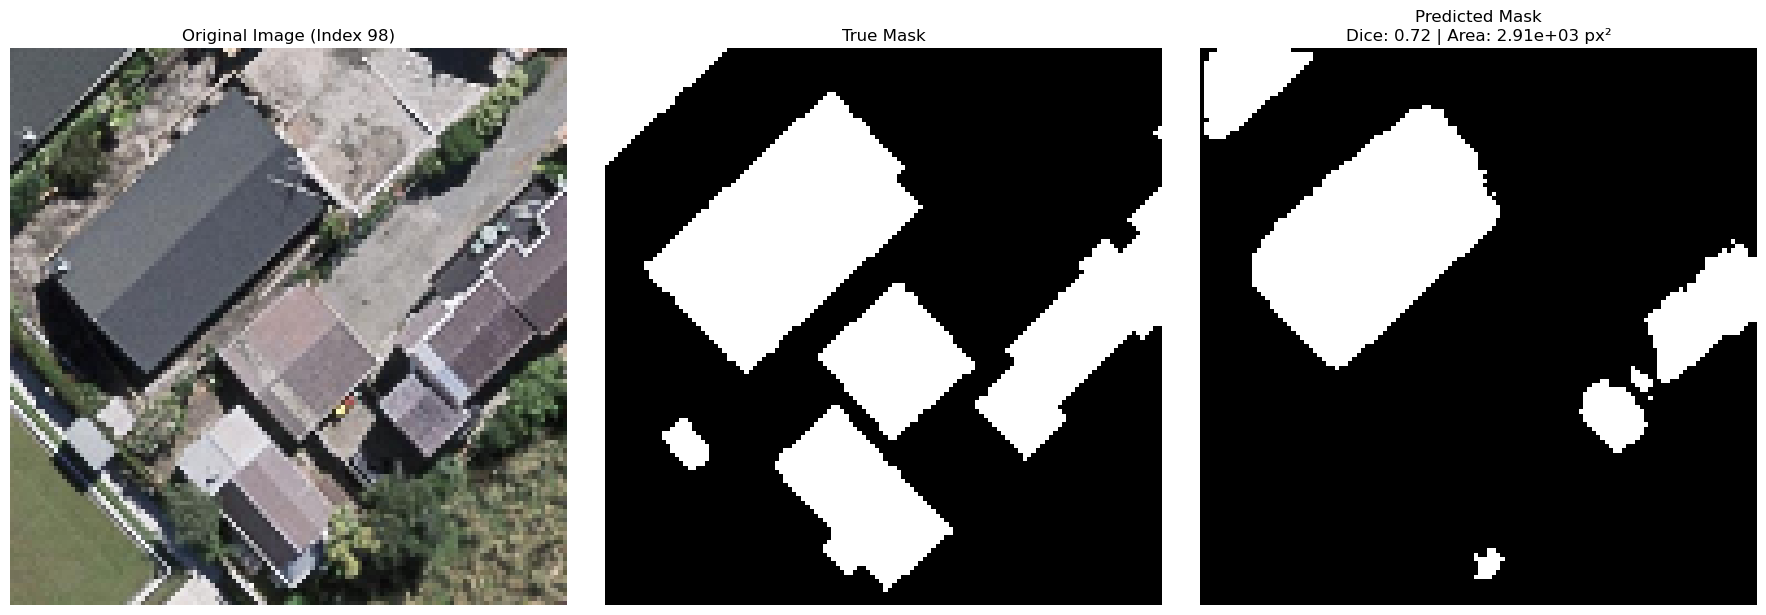

In [23]:
import random

# Evaluate overall validation loss and accuracy without verbose output.
val_loss, val_accuracy = model.evaluate(X_val, Y_val, batch_size=16, verbose=0)
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Dice coefficient function
def dice_coefficient(true_mask, pred_mask, smooth=1e-7):
    """
    Computes the Dice coefficient between the true mask and predicted mask.
    """
    true_flat = true_mask.flatten()
    pred_flat = pred_mask.flatten()
    intersection = np.sum(true_flat * pred_flat)
    return (2. * intersection + smooth) / (np.sum(true_flat) + np.sum(pred_flat) + smooth)

# Assuming calculate_mask_area(mask, threshold=0.5) is already defined:
# def calculate_mask_area(mask, threshold=0.5):
#     if mask.ndim == 3 and mask.shape[-1] == 1:
#         mask = np.squeeze(mask, axis=-1)
#     binary_mask = (mask > threshold).astype(np.uint8)
#     area = int(np.sum(binary_mask))
#     return area

# Set a threshold for a "good" prediction (based on Dice coefficient)
dice_threshold = 0.7
good_samples = []

# Iterate through the validation set and select samples that meet the criteria
for idx in range(len(X_val)):
    image = X_val[idx]
    true_mask = Y_val[idx]
    # Get prediction with no progress output.
    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
    
    # Skip if the predicted mask is completely empty.
    if np.sum(pred_mask_bin) == 0:
        continue
    
    dice_score = dice_coefficient(true_mask.squeeze(), pred_mask_bin.squeeze())
    
    # Only include samples with a Dice coefficient above the threshold.
    if dice_score >= dice_threshold:
        # Calculate the area of the predicted mask.
        area = calculate_mask_area(pred_mask_bin)
        good_samples.append((idx, dice_score, area))

print(f"Found {len(good_samples)} good samples out of {len(X_val)} total validation samples.")

# Randomly choose 5 examples from the good samples (or all if fewer than 5 exist)
num_examples = 5
if len(good_samples) < num_examples:
    print("Not enough good samples found; displaying all available.")
    selected_samples = good_samples
else:
    selected_samples = random.sample(good_samples, num_examples)

# Visualize the selected examples.
for (idx, dice_score, area) in selected_samples:
    image = X_val[idx]
    true_mask = Y_val[idx]
    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask_bin = (pred_mask > 0.5).astype(np.float32)
    
    # Format the area in scientific notation (e.g., "1.63e+03")
    area_formatted = f"{area:.2e}"
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    
    axs[0].imshow(image)
    axs[0].set_title(f"Original Image (Index {idx})")
    axs[0].axis("off")
    
    axs[1].imshow(true_mask.squeeze(), cmap='gray')
    axs[1].set_title("True Mask")
    axs[1].axis("off")
    
    axs[2].imshow(pred_mask_bin.squeeze(), cmap='gray')
    axs[2].set_title(f"Predicted Mask\nDice: {dice_score:.2f} | Area: {area_formatted} px²")
    axs[2].axis("off")
    
    plt.tight_layout()
    plt.show()

In [24]:
import tensorflow as tf
import pathlib

# Define the directory where your dataset is stored.
data_dir = pathlib.Path("satellite-images-val")

# Parameters for loading the images.
batch_size = 32
img_height = 180
img_width = 180

# Load the dataset using image_dataset_from_directory.
# By default, the labels are assigned in alphabetical order:
# flat -> 0, gabled -> 1, hipped -> 2.
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    class_names=["flat", "gabled", "hipped"],
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True
)

# Define a mapping function to adjust the labels:
# Add 1 to each label so that:
# flat: 0+1 -> 1, gabled: 1+1 -> 2, hipped: 2+1 -> 3.
def adjust_label(image, label):
    return image, label+1

# Apply the mapping to the dataset.
dataset = dataset.map(adjust_label)

# (Optional) Check one batch of labels to verify.
for images, labels in dataset.take(1):
    print("Adjusted labels:", labels.numpy())

Found 124 files belonging to 3 classes.
Adjusted labels: [1 1 3 3 3 3 3 3 2 3 2 1 3 3 1 2 1 2 2 1 2 3 2 3 2 3 1 3 3 2 2 1]


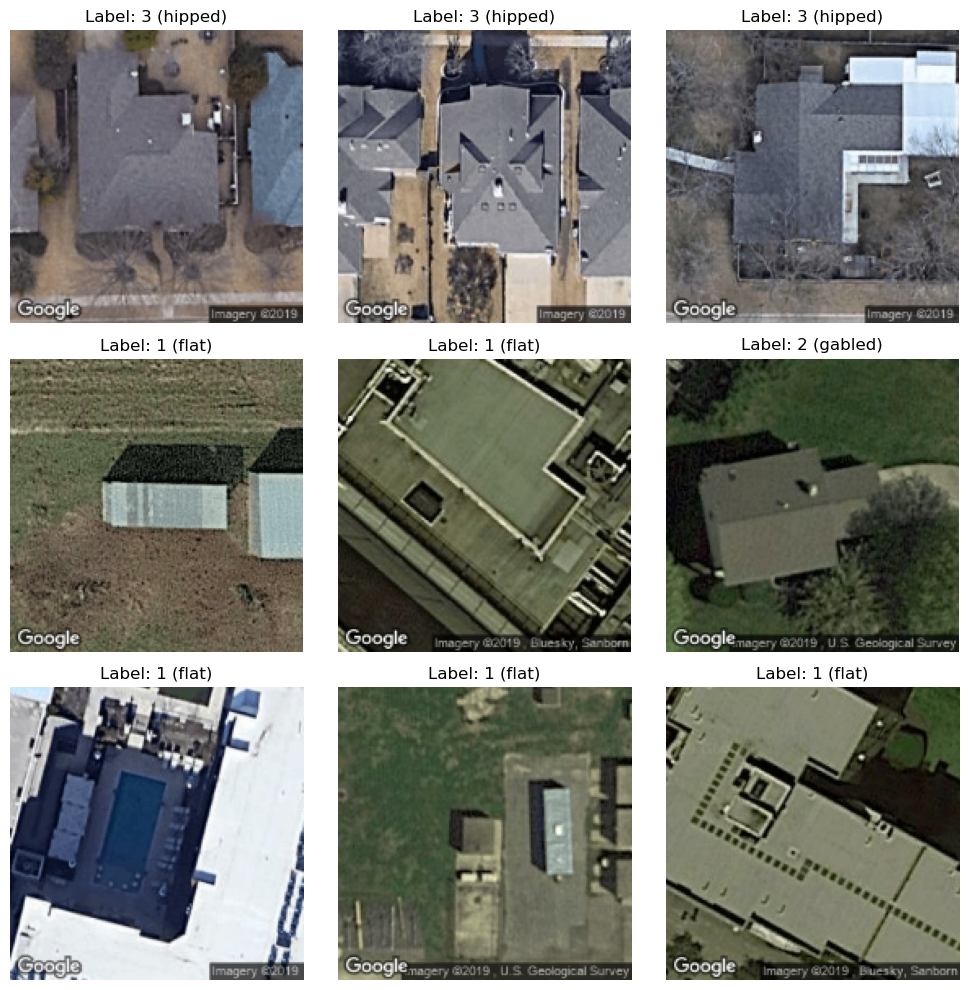

In [29]:
import matplotlib.pyplot as plt

# Create a mapping dictionary for labels
label_names = {1: "flat", 2: "gabled", 3: "hipped"}

# Visualize a few images from the dataset
plt.figure(figsize=(10, 10))

# Get one batch from the dataset
for images, labels in dataset.take(1):
    # Display the first 9 images in a 3x3 grid (adjust the range as needed)
    for i in range(min(len(images), 9)):
        ax = plt.subplot(3, 3, i + 1)
        # Convert image tensor to uint8 format
        plt.imshow(images[i].numpy().astype("uint8"))
        # Get the numerical label and its corresponding roof type
        label = labels[i].numpy()
        plt.title(f"Label: {label} ({label_names[label]})")
        plt.axis("off")

plt.tight_layout()
plt.show()


In [31]:
image_classifier = tf.keras.Sequential([
    tf.keras.Input(shape=(img_height, img_width, 3)),
    tf.keras.layers.Rescaling(1./255),
    
    # Convolutional block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Convolutional block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Convolutional block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Flatten and dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Output layer for 3 classes (using softmax activation)
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the classifier
image_classifier.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])

# Display the model architecture
image_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,363 (25.36 MB)

 Trainable params: 6,647,363 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Adjust the labels for training by subtracting 1 (so 1 -> 0, 2 -> 1, 3 -> 2)
dataset_adjusted = dataset.map(lambda image, label: (image, label - 1))

# Determine the number of batches in the dataset
dataset_size = tf.data.experimental.cardinality(dataset_adjusted).numpy()
val_batches = int(0.2 * dataset_size)
if val_batches < 1:
    val_batches = 1

# Split the dataset: use the first 20% for validation and the rest for training.
val_dataset = dataset_adjusted.take(val_batches)
train_dataset = dataset_adjusted.skip(val_batches)

# Set the number of epochs for training
epochs = 10

# Train the image_classifier on the train_dataset with validation on val_dataset
history = image_classifier.fit(train_dataset, validation_data=val_dataset, epochs=epochs)


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 583ms/step - accuracy: 0.7750 - loss: 0.5237 - val_accuracy: 0.7812 - val_loss: 0.4912
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 612ms/step - accuracy: 0.7811 - loss: 0.5032 - val_accuracy: 0.9688 - val_loss: 0.4548
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 686ms/step - accuracy: 0.8886 - loss: 0.4892 - val_accuracy: 0.9062 - val_loss: 0.2960
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 584ms/step - accuracy: 0.8988 - loss: 0.3256 - val_accuracy: 0.9062 - val_loss: 0.2722
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.9322 - loss: 0.2867 - val_accuracy: 0.9375 - val_loss: 0.1533
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 613ms/step - accuracy: 0.9798 - loss: 0.1438 - val_accuracy: 0.9062 - val_loss: 0.3743
Epoch 7/10
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.8750 - loss: 0.3155

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.9062 - loss: 0.2069
CV Loss: 0.20686452090740204
CV Accuracy: 0.90625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


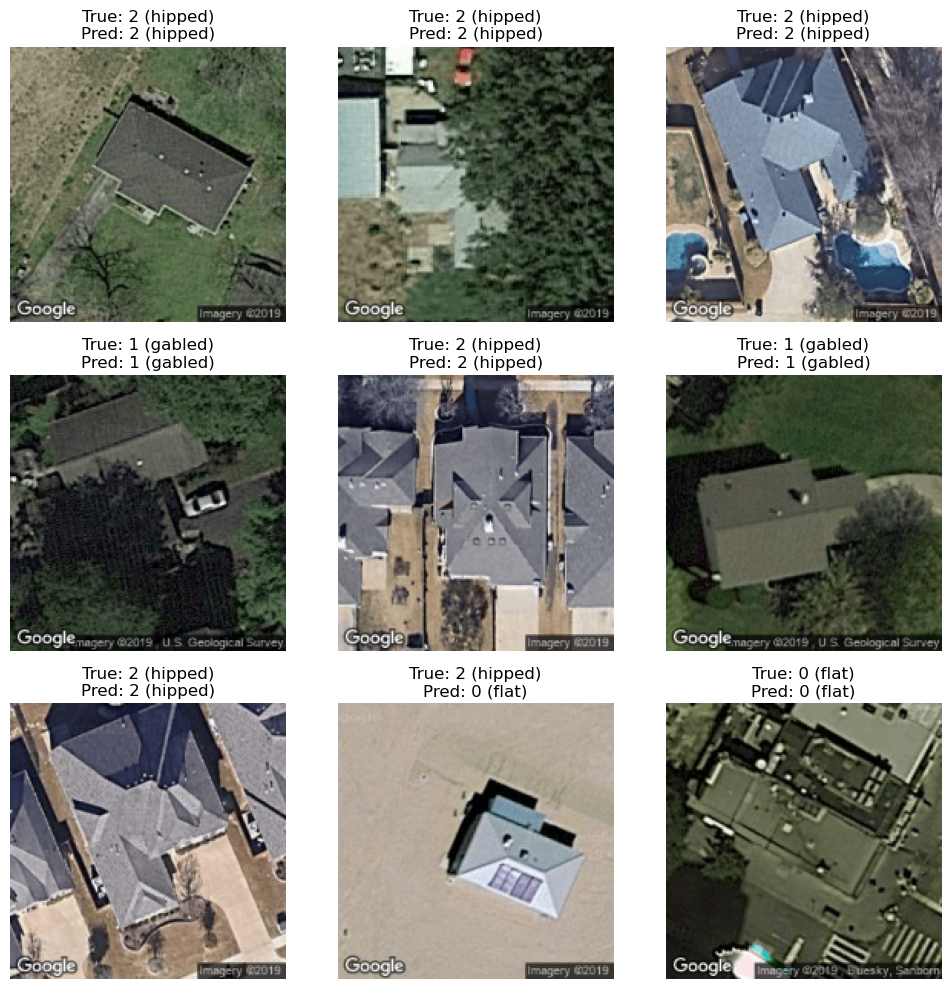

In [37]:
eval_loss, eval_accuracy = image_classifier.evaluate(val_dataset)
print("CV Loss:", eval_loss)
print("CV Accuracy:", eval_accuracy)

# Define a mapping for 0-indexed labels
label_names = {0: "flat", 1: "gabled", 2: "hipped"}

# Visualize predictions for a few images from the CV dataset
for images, labels in val_dataset.take(1):
    # Get the predictions from the model (returns probabilities for each class)
    predictions = image_classifier.predict(images)
    # Determine the predicted class by taking the argmax
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()  # these are already 0-indexed
    
    plt.figure(figsize=(10, 10))
    # Display the first 9 images in a 3x3 grid
    for i in range(min(len(images), 9)):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"True: {true_classes[i]} ({label_names[true_classes[i]]})\n"
                  f"Pred: {predicted_classes[i]} ({label_names[predicted_classes[i]]})")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


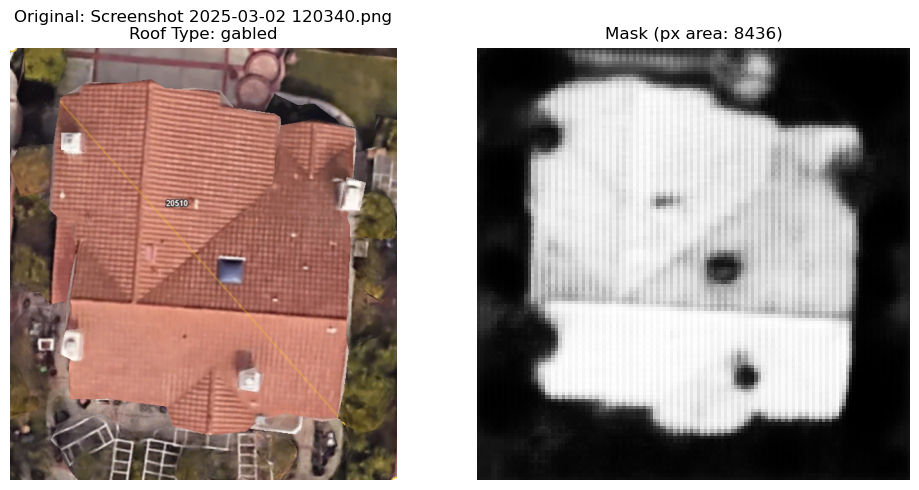

Image: Screenshot 2025-03-02 120340.png
  - Roof Type: gabled
  - Mask Area (px²): 8436
  - Roof Area (m²): 315.37
  - Solar Potential (W): 12,266.70
------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


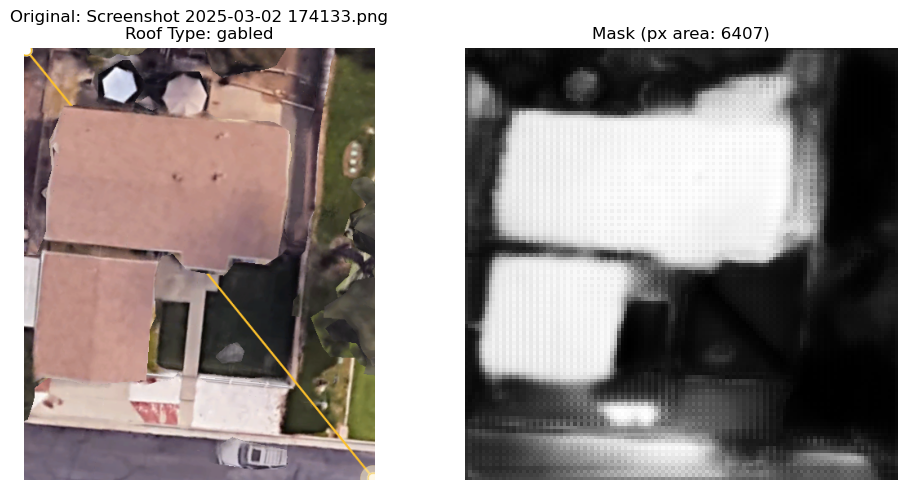

Image: Screenshot 2025-03-02 174133.png
  - Roof Type: gabled
  - Mask Area (px²): 6407
  - Roof Area (m²): 239.52
  - Solar Potential (W): 9,316.35
------------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


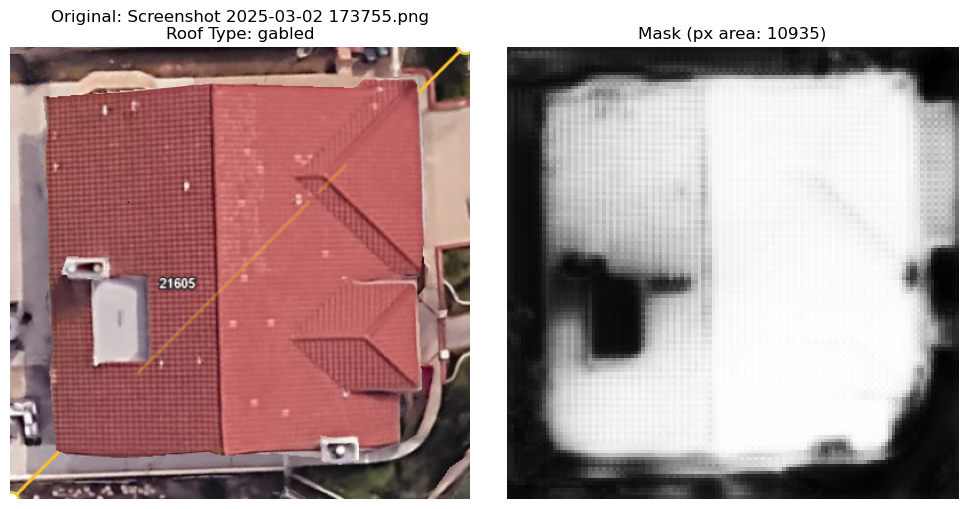

Image: Screenshot 2025-03-02 173755.png
  - Roof Type: gabled
  - Mask Area (px²): 10935
  - Roof Area (m²): 408.79
  - Solar Potential (W): 15,900.47
------------------------------------------------



In [49]:
# ----------------------
#    CONSTANTS
# ----------------------

# Conversion factor from mask px² to m² (your specific calculated value)
PIXEL_TO_M2 = 0.0373840332

# If your classifier outputs: 0 -> flat, 1 -> gabled, 2 -> hipped
LABEL_NAMES = {0: "flat", 1: "gabled", 2: "hipped"}

# Convert 5.0 kWh/m^2/day to average W/m^2:
# 1 kWh/m^2/day ≈ 41.667 W/m^2
# 5.0 kWh/m^2/day → ~208 W/m^2
SOLAR_IRRADIANCE_W_PER_M2 = 208.0

# Panel efficiency & system efficiency
PANEL_EFFICIENCY = 0.22   # 22%
SYSTEM_EFFICIENCY = 0.85  # 85%

# ----------------------
#    HELPER FUNCTIONS
# ----------------------

def load_image_for_segmentation(image_path, target_size=(128, 128)):
    """
    Loads an image from disk for the segmentation model:
      - Reads with OpenCV
      - Converts BGR -> RGB
      - Resizes to (128 x 128)
      - Normalizes [0..1]
      - Adds batch dimension
    Returns: (1, 128, 128, 3) float32 array
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot read image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return np.expand_dims(image.astype(np.float32), axis=0)

def load_image_for_classification(image_path, target_size=(180, 180)):
    """
    Loads an image from disk for the classification model:
      - Reads with OpenCV
      - Converts BGR -> RGB
      - Resizes to (180 x 180)
      - Normalizes [0..1]
      - Adds batch dimension
    Returns: (1, 180, 180, 3) float32 array
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot read image at {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return np.expand_dims(image.astype(np.float32), axis=0)

def calculate_mask_area(mask, threshold=0.5):
    """
    Calculates the total number of pixels above the given threshold in the mask.
    
    mask could be (1, H, W, 1) or (H, W, 1), so we squeeze out redundant dims.
    """
    # Remove batch dim if present
    if mask.ndim == 4 and mask.shape[0] == 1:
        mask = np.squeeze(mask, axis=0)
    # Remove channel dim if present
    if mask.ndim == 3 and mask.shape[-1] == 1:
        mask = np.squeeze(mask, axis=-1)
    
    binary_mask = (mask > threshold).astype(np.uint8)
    px_area = int(np.sum(binary_mask))
    return px_area

# ----------------------
#    MAIN FUNCTION
# ----------------------

def process_random_images(dataset_folder="datset", num_samples=3):
    """
    1. Randomly picks `num_samples` images from `dataset_folder`.
    2. Runs each image through:
       a. Segmentation model (`model`) to get a mask and compute area in px -> m²
       b. Classification model (`image_classifier`) to get roof type
       c. Calculates solar potential in W using the formula:
          P(W) = area(m²) * G(W/m²) * panel_eff * system_eff
    3. Displays original image + mask side-by-side, and prints results.
    """
    # Gather image files
    all_files = [
        f for f in os.listdir(dataset_folder)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ]
    
    if not all_files:
        print(f"No images found in {dataset_folder}.")
        return
    
    # Randomly pick up to num_samples
    sample_files = random.sample(all_files, min(num_samples, len(all_files)))

    for img_name in sample_files:
        img_path = os.path.join(dataset_folder, img_name)
        
        # (A) SEGMENTATION
        seg_input = load_image_for_segmentation(img_path)
        predicted_mask = model.predict(seg_input)  # shape: (1, 128, 128, 1)
        
        px_area = calculate_mask_area(predicted_mask, threshold=0.5)
        roof_area_m2 = px_area * PIXEL_TO_M2
        
        # (B) CLASSIFICATION
        class_input = load_image_for_classification(img_path)
        class_probs = image_classifier.predict(class_input)
        predicted_idx = np.argmax(class_probs[0])
        roof_type = LABEL_NAMES[predicted_idx]
        
        # (C) SOLAR POTENTIAL CALC
        solar_potential_watts = (
            roof_area_m2 *
            SOLAR_IRRADIANCE_W_PER_M2 *
            PANEL_EFFICIENCY *
            SYSTEM_EFFICIENCY
        )
        
        # (D) VISUALIZATION
        original_img = cv2.imread(img_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
        
        display_mask = np.squeeze(predicted_mask, axis=0)  # (128, 128, 1)
        display_mask = np.squeeze(display_mask, axis=-1)   # (128, 128)

        plt.figure(figsize=(10, 5))
        
        # 1) Original
        plt.subplot(1, 2, 1)
        plt.title(f"Original: {img_name}\nRoof Type: {roof_type}")
        plt.imshow(original_img)
        plt.axis("off")

        # 2) Mask
        plt.subplot(1, 2, 2)
        plt.title(f"Mask (px area: {px_area})")
        plt.imshow(display_mask, cmap="gray")
        plt.axis("off")

        plt.tight_layout()
        plt.show()
        
        # (E) PRINT RESULTS
        print(f"Image: {img_name}")
        print(f"  - Roof Type: {roof_type}")
        print(f"  - Mask Area (px²): {px_area}")
        print(f"  - Roof Area (m²): {roof_area_m2:.2f}")
        print(f"  - Solar Potential (W): {solar_potential_watts:,.2f}")
        print("------------------------------------------------\n")

process_random_images(dataset_folder="datset", num_samples=3)


NameError: name 'model' is not defined